# 一、环境准备

在命令行中执行下面的命令，安装 Python 依赖库

pip3 install -r requirements.txt

辅助文档：https://yju67c1ngj.feishu.cn/docx/LJ1zd5sVNoQcubxVySucKAWqnfb

下文提到的 @todo 项 需要替换为自己的，主要是 cookie 参数

In [3]:
import matplotlib.pyplot as plt
# 设置中文字体，解决 plt 绘图中文不显示问题
plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
# 用于正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# 二、爬虫获取破局星球精华文章

In [4]:
from urllib.parse import quote
import time
import random
import requests
from fake_useragent import UserAgent


# 从指定星球 url获 取数据
def get_data(url):
    ua = UserAgent()
    # 每次调用生成一个随机的 agent，防止被限流
    user_agent = ua.random
    # @todo 注意下面的cookie参数需要替换为你自己的，登录知识星球后查看接口网络请求，复制修改下面的参数
    # cookie 包含你的登录信息，如果返回状态码 401，代表 cookie 过期，需要更换最新登录的 cookie
    headers_group = {
        "accept": "application/json, text/plain, */*",
        "accept-encoding": "gzip, deflate, br",
        "accept-language": "zh-CN,zh;q=0.9",
        "cache-control": "no-cache",
        "cookie": "UM_distinctid=188126c9de5337-07a7abb9fd0331-1b525635-13c680-188126c9de61027;",
        "dnt": "1",
        "origin": "https://wx.zsxq.com",
        "pragma": "no-cache",
        "referer": "https://wx.zsxq.com/",
        "sec-ch-ua": '"Chromium";v="104", " Not A;Brand";v="99", "Google Chrome";v="104"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": "macOS",
        "sec-fetch-dest": "empty",
        "sec-fetch-mode": "cors",
        "sec-fetch-site": "same-site",
        "user-agent":  user_agent,
        "x-request-id": "820c80e29-2bf0-4d33-fb8d-3dc621004ad",
        "x-signature": "53998a061597cf1c91e06bd3a2f6fa7935ad2d73",
        "x-timestamp": "1698673871",
        "x-version": "2.45.0",
    }
    max_retries = 5
    for _ in range(max_retries):
        rsp = requests.get(url, headers=headers_group)
        topics = rsp.json().get('resp_data').get('topics')

        print("获取数据", rsp.status_code, len(topics) if topics is not None else 0)
        if rsp.status_code == 200 and topics is not None:
            return topics
        time.sleep(5)  # 等待5秒重试

 
    return []

# 破局星球精华 url
url = "https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20"
next_page = get_data(url)
topics = next_page
# 如果有数据，拉取下一页
while next_page:
    # 上一页最后一篇文章的发表时间
    create_time = next_page[-1].get('create_time')
    # 发表时间格式化（空余填充 0）
    end_time = create_time[:20]+str(int(create_time[20:23])-1).zfill(3)+create_time[23:]
    # 时间出现整点时需要特殊处理，否则会出现 -1
    if create_time[20:23] == '000':
        temp_time = datetime.datetime.strptime(create_time, "%Y-%m-%dT%H:%M:%S.%f+0800")
        temp_time += datetime.timedelta(seconds=-1)
        end_time = temp_time.strftime("%Y-%m-%dT%H:%M:%S") + '.999+0800'
    # url 参数格式化
    end_time = quote(end_time)
    # 拼接 下一页需要的 end_time 字段
    next_url = url + '&end_time=' + end_time
    # 随机等待 10 ~ 20 s
    time.sleep(random.uniform(10, 20))
    # 请求下一页
    next_page = get_data(next_url)
    if next_page:
        topics = topics + next_page
        print("next_page", len(next_page), len(topics), next_url)

print(len(topics))

获取数据 200 20
获取数据 200 20
next_page 20 40 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-10-25T17%3A26%3A48.002%2B0800
获取数据 200 20
next_page 20 60 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-10-09T20%3A00%3A44.352%2B0800
获取数据 200 20
next_page 20 80 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-09-22T00%3A56%3A02.621%2B0800
获取数据 200 20
next_page 20 100 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-09-09T22%3A53%3A48.955%2B0800
获取数据 200 20
next_page 20 120 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-08-17T02%3A11%3A27.261%2B0800
获取数据 200 20
next_page 20 140 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20&end_time=2023-07-25T23%3A30%3A16.564%2B0800
获取数据 200 20
next_page 20 160 https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&c

# 三、json 数据 同步到文件中

In [5]:
import json
# Serializing json
print(len(topics))
json_object = json.dumps(topics, indent=4, ensure_ascii=False)
# Writing to sample.json
with open("topics.json", "w") as outfile:
    outfile.write(json_object)

331


# 四、数据预处理

In [9]:
import pandas as pd
from  datetime import datetime
tmpArr = []
for item in topics:
    # 过滤无效的文章
    if 'talk' not in item:
        print("No talk", item)
        continue
    
    # 文章内容分两种形式：纯文本 + 链接
    if 'article' not in item['talk']:        
        title = item["talk"]["text"]
        html_content = item["talk"]["text"]
        acticle_url = ""
    else:
        title = item["talk"]["article"]["title"]
        html_content = requests.get(item["talk"]["article"]["inline_article_url"]).content
        acticle_url = item["talk"]["article"]["inline_article_url"]
    tmpArr.append(
        {
            "title": title,
            "owner": item["talk"]["owner"]["name"],
            "location": item["talk"]["owner"]["location"],
            "create_time": item["create_time"],
            "readers_count": item["readers_count"],
            "likes_count": item["likes_count"],
            "article_url": acticle_url,
            "hour": datetime.strptime(item["create_time"], "%Y-%m-%dT%H:%M:%S.%f%z").hour
        }
    )
df = pd.DataFrame(tmpArr)
df.to_csv("topics.csv")
df.head()
df = df[df['owner'] != 'findyi']
print(df.shape)


No talk {'topic_id': 588114542582444, 'group': {'group_id': 15552545485212, 'name': 'AI破局俱乐部', 'type': 'pay', 'background_url': 'https://images.zsxq.com/FslG2Iw17zo1nk4F_XhCrWvxbcR7?e=1704038399&token=kIxbL07-8jAj8w1n4s9zv64FuZZNEATmlU_Vm6zD:tsqPd2LDgT-ZwGcDtvh4t4SVTmk='}, 'type': 'q&a', 'question': {'owner': {'user_id': 88285254518482, 'name': '飞机Fitz', 'avatar_url': 'https://images.zsxq.com/FkMvntdSHxxZNuoGUAmpfXJX5TK8?e=1704038399&token=kIxbL07-8jAj8w1n4s9zv64FuZZNEATmlU_Vm6zD:Hi1cKOPVQshFN_uPzv6a0ylpPPM=', 'location': '上海'}, 'questionee': {'user_id': 51544811224184, 'name': 'findyi', 'avatar_url': 'https://images.zsxq.com/FjoYYKf24IAnA-qdduT3wHfrs9KX?e=1704038399&token=kIxbL07-8jAj8w1n4s9zv64FuZZNEATmlU_Vm6zD:bk0m5aITgrVp250Z0TI5A5d7XtY=', 'description': '前360技术总监、担任过独角兽公司CTO、腾讯TVP', 'location': '北京'}, 'text': '洋哥好呀～\n我最近一直在思考一个问题“ai时代，一个人的核心竞争力到底会是什么？”\n\n会是ai这类工具吗？不知道您怎么想，我觉得肯定不是。\n\n我应该是最早加入星球的那批用户。当时进来真的像是打开了一个新世界，每天都有海量的信息和知识涌入，刺激着我的感官。我也不断练习着写作，提示词和绘画。但越来越发现他给我带来的边际效益在递减。快速上手

# 五、文章作者拆解

In [10]:

# 统计每位作者的文章数
author_article_counts = df['owner'].value_counts().reset_index()
author_article_counts.columns = ['author', 'article_count']
# 展示前 10个 作者
author_article_counts.head(10)

,author,article_count
0,小潘,21
1,吴东子,14
2,皮特,9
3,闫小林,9
4,小七姐,8
5,鱼皮,7
6,元峰,7
7,段老湿,6
8,潘达,5
9,竹子 | 洋哥助理,4


# 六、作者所在城市分析

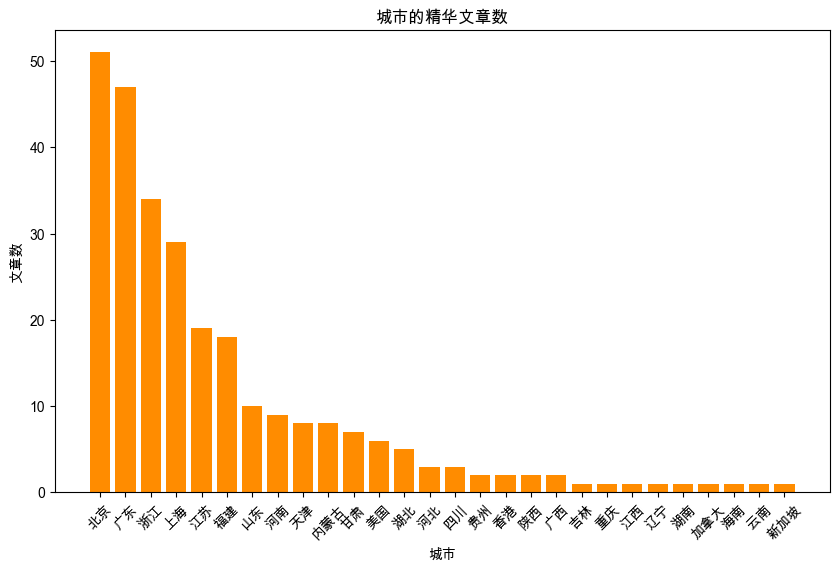

In [11]:
# 覆盖了多少个城市
# 统计每位作者的文章数
metrics = df['location'].value_counts().reset_index()
metrics.columns = ['X', 'Y']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(metrics['X'], metrics['Y'], color='darkorange')
plt.xlabel('城市')
plt.ylabel('文章数')
plt.title('城市的精华文章数')
plt.xticks(rotation=45)  # 旋转 X 轴标签，使其更易读
plt.show()

# 七、文章发表时间分析

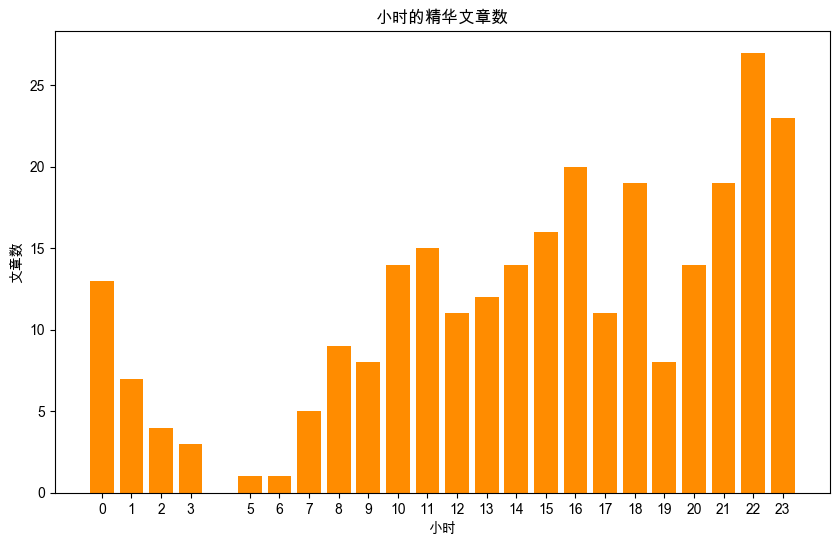

In [12]:
metrics = df['hour'].value_counts().reset_index()
metrics.columns = ['X', 'Y']

# 绘制柱状图
plt.figure(figsize=(10, 6))
metrics
plt.bar(metrics['X'], metrics['Y'], color='darkorange')
plt.xlabel('小时')
plt.ylabel('文章数')
plt.title('小时的精华文章数')
plt.xticks(metrics['X']) # 设置 x 轴刻度和标签
# plt.xticks(rotation=45)  # 旋转 X 轴标签，使其更易读
plt.show()

# 八、阅读数分析

## 一）查看某个作者的文章

In [13]:
df2 = df[df['article_url'] != '']
print(df.shape)
df2 = df[df['owner'] == '木川']
print(df2.shape)

df_sorted = df2.sort_values(by="readers_count", ascending=False)
for index, row in df_sorted.iterrows():
    print(f"title: {row['title'][:30]}, owner: {row['owner']}, article_url: {row['article_url']}, {row['readers_count']}, {row['likes_count']}")

(274, 8)
(2, 8)
title: CodeGeex 编程大模型应用复盘, owner: 木川, article_url: https://articles.zsxq.com/inline_form/id_arb464kfrkjn.html, 5845, 89
title: 我用 AI + 编程拆解了破局 300+ 精华文章，我惊呆了, owner: 木川, article_url: https://articles.zsxq.com/inline_form/id_wu8tqxikt3wo.html, 2079, 117


## 二）计算不同分位数下的文章阅读数，绘制箱线图

50 分位数：6664.0
75 分位数：10411.25
90 分位数：12751.2
95 分位数：13534.949999999988
100 分位数：20783.0


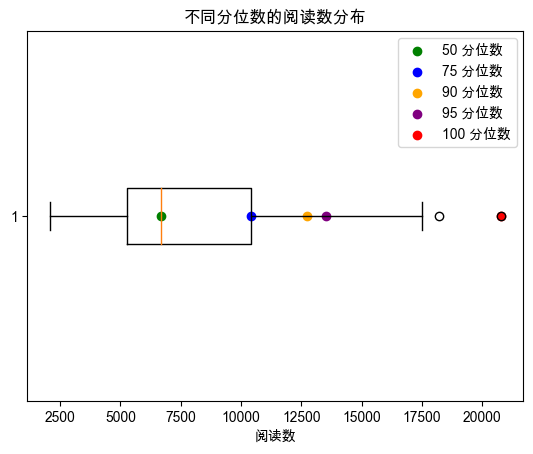

In [14]:
import matplotlib.pyplot as plt
import numpy as np

readership_data = df["readers_count"]

# 创建箱线图
# 计算不同分位数
percentiles = [50, 75, 90, 95, 100]
percentile_values = np.percentile(readership_data, percentiles)

# 打印分位数的值
for p, value in zip(percentiles, percentile_values):
    print(f"{p} 分位数：{value}")

# 绘制箱线图
plt.boxplot(readership_data, vert=False)

# 添加不同颜色的分位数标识
colors = ['green', 'blue', 'orange', 'purple', 'red']
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.scatter(value, 1, color=color, marker='o', label=f"{p} 分位数")

# 设置标签和标题
plt.xlabel("阅读数")
plt.title("不同分位数的阅读数分布")

# 添加图例
plt.legend()

# 显示图表
plt.show()

## 三）统计不同阅读数区间的文章数，绘制直方图

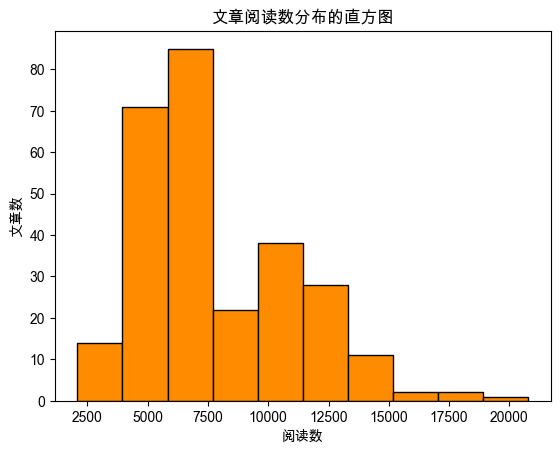

In [15]:
import matplotlib.pyplot as plt
import numpy as np

readership_data = df["readers_count"]
plt.hist(readership_data, bins=10, color='darkorange', edgecolor='k')

plt.xlabel("阅读数")
plt.ylabel("文章数")
plt.title("文章阅读数分布的直方图")
plt.show()

## 四）统计阅读数 top 10 的文章

In [16]:
df_sorted = df.sort_values(by="readers_count", ascending=False)
top_10 = df_sorted.head(10)
top_10[['title', 'owner', 'readers_count', 'article_url']]

,title,owner,readers_count,article_url
247,0代码基础小白使用ChatGPT做出一款谷歌全屏截图插件的全过程,阿强,20783,https://articles.zsxq.com/inline_form/id_grll0...
244,如何利用 ChatGPT 辅助写作,闫小林,18195,https://articles.zsxq.com/inline_form/id_9xwa8...
321,第三课-常用的AI应用（100款）,王强@ZelinAI,17508,https://articles.zsxq.com/inline_form/id_g7vpi...
245,如何用ChatGPT， 每天自动批量产出100+条爆款短视频,🍀刘驴💥,15976,https://articles.zsxq.com/inline_form/id_e74ag...
316,AI 到了iphone 时刻，现在在AI领域学习一年，相当于其他行业混十年,吴世春,15604,
296,阿里通义千问试玩~,鱼皮,14805,https://articles.zsxq.com/inline_form/id_1orqj...
280,使用AI，做抖音漫画短视频，4个人2天的工作量，1人仅需5小时即可完成！,蛋解创业蛋蛋,14583,https://articles.zsxq.com/inline_form/id_4kdt0...
241,如何用好ChatGPT，10倍提升输出效果🎉\n\n大家好，我是潘达。\n\n之前直播连麦洋...,潘达,14432,
255,"<e type=""hashtag"" hid=""28885111111551"" title=""...",鱼皮,14244,
301,分享一下我是如何用AI助手来提升工作效率的,王强@ZelinAI,14239,https://articles.zsxq.com/inline_form/id_zwopk...


# 九、点赞数分析

## 二）计算不同分位数下的文章点赞数，绘制箱线图

50 分位数：151.0
75 分位数：213.0
90 分位数：290.80000000000007
95 分位数：320.34999999999997
100 分位数：523.0


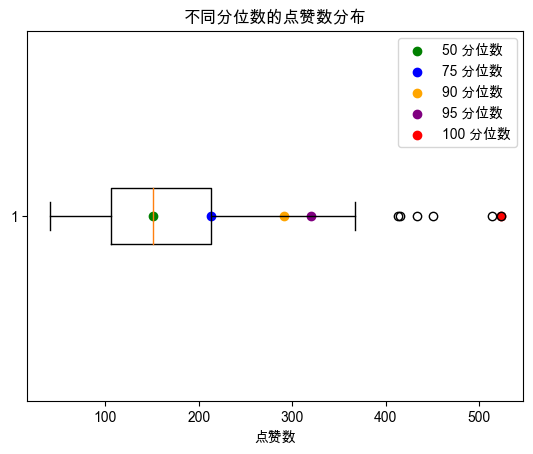

In [17]:

readership_data = df["likes_count"]
# 创建箱线图
# 计算不同分位数
percentiles = [50, 75, 90, 95, 100]
percentile_values = np.percentile(readership_data, percentiles)

# 打印分位数的值
for p, value in zip(percentiles, percentile_values):
    print(f"{p} 分位数：{value}")

# 绘制箱线图
plt.boxplot(readership_data, vert=False)

# 添加不同颜色的分位数标识
colors = ['green', 'blue', 'orange', 'purple', 'red']
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.scatter(value, 1, color=color, marker='o', label=f"{p} 分位数")

# 设置标签和标题
plt.xlabel("点赞数")
plt.title("不同分位数的点赞数分布")

# 添加图例
plt.legend()

# 显示图表
plt.show()

## 三）统计不同点赞数区间的文章数，绘制直方图

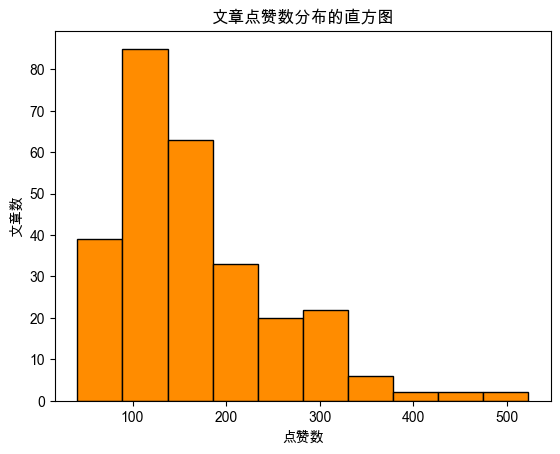

In [19]:
import matplotlib.pyplot as plt

readership_data = df["likes_count"]
plt.hist(readership_data, bins=10, color='darkorange', edgecolor='k')

plt.xlabel("点赞数")
plt.ylabel("文章数")
plt.title("文章点赞数分布的直方图")
plt.show()

## 四）统计点赞数 top 10 的文章

In [20]:
df_sorted = df.sort_values(by="likes_count", ascending=False)
top_10 = df_sorted.head(10)
top_10[['title', 'owner', 'likes_count', 'article_url']]

,title,owner,likes_count,article_url
244,如何利用 ChatGPT 辅助写作,闫小林,523,https://articles.zsxq.com/inline_form/id_9xwa8...
241,如何用好ChatGPT，10倍提升输出效果🎉\n\n大家好，我是潘达。\n\n之前直播连麦洋...,潘达,513,
196,爆肝10天，超级详细进阶SD教程 ! ！！\n大家好我是浦睿，一名大二在校生；SD绘画热爱者...,无忆,450,
247,0代码基础小白使用ChatGPT做出一款谷歌全屏截图插件的全过程,阿强,433,https://articles.zsxq.com/inline_form/id_grll0...
251,我做的AI律所：不仅律师自发传播，竟然还吸引了大佬王小川？,台风-2号,415,https://articles.zsxq.com/inline_form/id_oug13...
245,如何用ChatGPT， 每天自动批量产出100+条爆款短视频,🍀刘驴💥,413,https://articles.zsxq.com/inline_form/id_e74ag...
201,《0成本日入1000+小红书卖头像赚钱案例含开店流程！》\n大家好，我是艾克，我又来了。只分...,艾克,367,
281,4个公式8个案例学会与chatGPT对话,星球助理-matao,362,https://articles.zsxq.com/inline_form/id_jlxv2...
239,给送每一个AI创业者的避坑指南,叫我峰兄,349,https://articles.zsxq.com/inline_form/id_02dga...
192,"我在今日头条，用AI写稿变现，3分钟出一篇，收益1,195.26元，分享方法\n\n情感类文...",贺翔,348,


# 十、关键词拆解

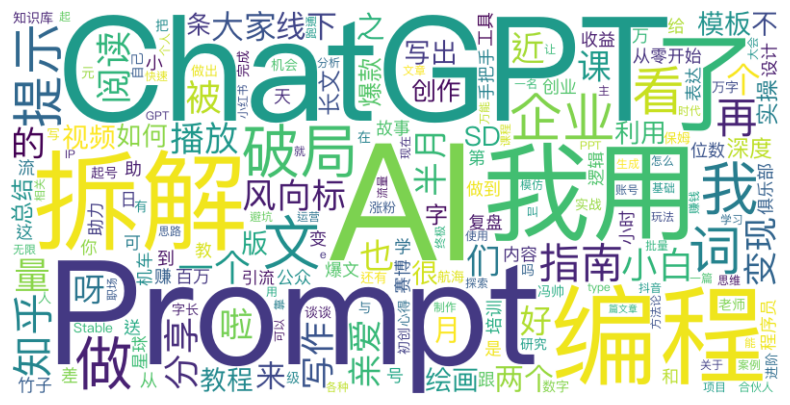

In [22]:
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 准备文本数据
words = []
for index, row in df.iterrows():
    title = row.title[:24]
    keywords = jieba.cut(title)
    # print(title, " ".join(keywords))
    for item in keywords:
        words.append(item)
# 使用Counter统计元素出现的次数
element_counts = Counter(words)

# 提取出现次数为2次或更多的元素
result = [element for element, count in element_counts.items() if count >= 2]
text = " ".join(result)

# @todo 修改中文字体文件路径，创建词云对象并生成词云图像
font_path = "../fonts/PingFang.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

# 显示词云图像
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 隐藏坐标轴
plt.show()